## Google-Symptoms DAP Appendix I: Correlation Analysis

Analyst: Jingjing

Advisors: Jacob and Nat

Stackholder: Ryan and Nigam

In [82]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Introduction

In the main report, we see the difference in the performance of correlation analysis for different indicators. However, multiple settings make the results not convincing enough. Recall that the list of available counties for different indicators can vary largely. An interesting point is, why sensory's performance is much better than other symptom sets? Is this determined by the nature of the symptom set itself, or just determined by the specialty of these ~100 counties? In terms of geo-wise correlation, what we will get using data sensorized with a certain as of date instead of considering data with different as of dates? Besides, providing ancillary information, we will also conduct a simple sanity check in this Appendix.

In [2]:
import re
from itertools import product
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from scipy.stats import spearmanr, rankdata
import seaborn as sns

import pandas as pd
import numpy as np

import covidcast
from delphi_utils import GeoMapper


gmpr = GeoMapper()

### Time-wise correlation analysis with a limited number of counties considered

To figure out why Sensory stands out, we stabilized the list of counties considered to be the same list with ~100 counties that are available for all the symptom sets including Sensory. Though results are much different from what we can see in the plots shown in the main DAP report, we don't see the specialty of these selected counties in general. We still think Sensory has a much better time-wise correlation than any other symptoms sets. In terms of the difference between these plots and the plots in the main DAP, we can see that 1) the lines here are more fluctuated for symptom sets except for Sensory which is intuitive; 2) there are peaks around mid-July for all the lines with regression method and also peaks for lines of Fatigue, GI, Sensory and Pain with rawsum method. However, there are valleys on the lines for Fever and Respiratory with rawsum method. A reasonable guess is that some of the symptoms in these two sets and the confirmed incidence case rates have a larger lag in time near the mid-July peak. A similar situation appeared in November and December.

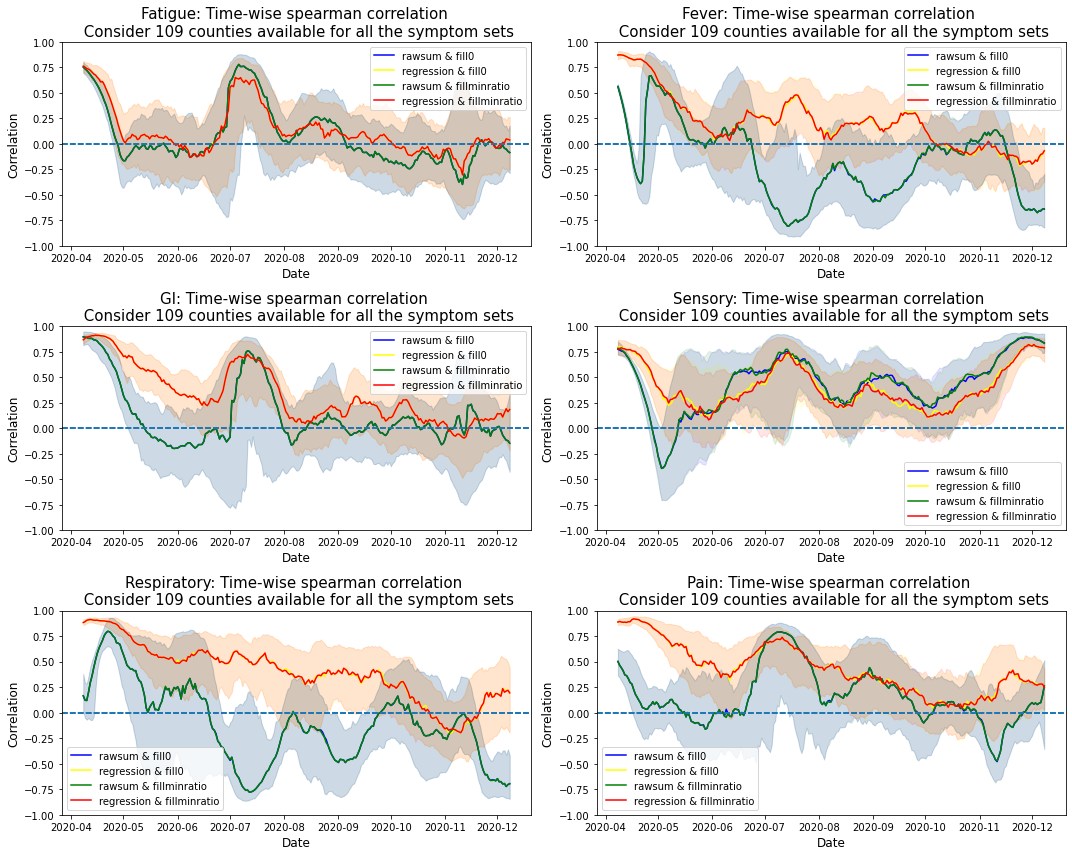

In [95]:
geo_list = pd.read_csv("./sensorization_with_as_of_02/sensored/%s_%s_%s_sensorization_12_14.csv"%("Sensory", "regression", "fill0"), 
                     parse_dates=["date"]).dropna()["geo_id"].unique()
geo_list = [str(x).zfill(5) for x in geo_list]
plt.figure(figsize = (15, 12))
i=1
corr_dfs = {}
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    for fillmissingness in ["fill0", "fillminratio"]:
        corr_dfs[fillmissingness] = {}
        for method in ["rawsum", "regression"]:
            corr_dfs[fillmissingness][method] = {}
                    
            corr_dfs[fillmissingness][method][signal] = pd.read_csv("./sensorization_with_as_of_02/time_wise_corr/%s_corr_df_%s_%s.csv"%(signal,
                                                                                            method,
                                                                                            fillmissingness),
                                                                   parse_dates=["date"]) 
            corr_dfs[fillmissingness][method][signal]["county"] = [str(x).zfill(5) for x in corr_dfs[fillmissingness][method][signal]["county"]]

            current_df = corr_dfs[fillmissingness][method][signal]
            current_df = current_df[current_df["county"].isin(geo_list)]
            plot_df = current_df.groupby("date")["correlation"].median().reset_index()
            plot_75_df = current_df.groupby("date")["correlation"].quantile(0.75).reset_index()
            plot_25_df = current_df.groupby("date")["correlation"].quantile(0.25).reset_index()
            plt.plot(plot_df["date"], plot_df["correlation"], label="%s & %s"%(method, fillmissingness),
                    color = color_dict[(fillmissingness, method)])
            plt.fill_between(plot_df["date"], plot_75_df["correlation"], 
                             plot_25_df["correlation"],
                             color=color_dict[(fillmissingness, method)], alpha=0.1,
                             interpolate=True)          
            plt.title("%s: Time-wise spearman correlation \n Consider 109 counties available for all the symptom sets"%signal, fontsize=15)
            plt.ylim((-1, 1))
            plt.xlabel("Date", fontsize=12)
            plt.ylabel("Correlation", fontsize=12)
            plt.axhline(0, linestyle="--")
            plt.legend()

#plt.legend(bbox_to_anchor=(0.5, -0.25))
plt.tight_layout()

To confirm our conjecture, we drew the time series lines for smoothed google symptoms with missing values filled using fillminratio method. The lines represent the median of the scaled values across the 109 selected counties and the scaling factors are the maximum popularity of each symptom during the time period. Compared with the trend of confirmed incidence case rates, we can see Hyperthermia in Fever, Asthma, and Cough in Respiratory can obviously serve as leading indicators if considering the peak in mid-July only. Actually, nearly all the symptoms in Fever and Respiratory show advanced peaks in mid-March while the dramatic increase of case rates appears in early April.

Remember the Google symptoms values are pre-scaled according to a regionally specific population of search users and the maximum value of the normalized popularity overall symptoms. During the sensorization step, we do not make any further scaling or normalization. This means that the overall popularity of different symptoms is likely to vary largely which can be shown in the plots below. If rawsum is used to combine multiple symptoms, the indicator can be dominated by symptoms that have the largest overall popularity.

In [77]:
symptom_sets = {
    "Respiratory": ["symptom:Cough", "symptom:Phlegm", "symptom:Shortness of breath", "symptom:Wheeze",
                        "symptom:Asthma", "symptom:Pneumonia", "symptom:Sore throat"],
    "Sensory": ["symptom:Anosmia", "symptom:Dysgeusia", "symptom:Ageusia"],
    "Fever": ["symptom:Fever", "symptom:Hyperthermia", "symptom:Chills", "symptom:Shivering"],
    "Fatigue": ["symptom:Fatigue", "symptom:Weakness"],
    "GI": ["symptom:Nausea", "symptom:Vomiting", "symptom:Diarrhea", "symptom:Indigestion",
          "symptom:Abdominal pain"],
    "Pain": ["symptom:Pain", "symptom:Sharp pain", "symptom:Chest pain", "symptom:Myalgia",
             "symptom:Arthralgia", "symptom:Eye pain", "symptom:Headache", "symptom:Migraine",
             "symptom:Cramp"]
}
gs_df = pd.read_csv("./raw/county_fillminratio_smoothed_google_symptoms_12_14.csv", parse_dates=["date"])
geo_list = pd.read_csv("./sensorization_with_as_of/sensored/%s_%s_%s_sensorization_12_14.csv"%("Sensory", "regression", "fill0"), 
                     parse_dates=["date"]).dropna()["geo_id"].unique()

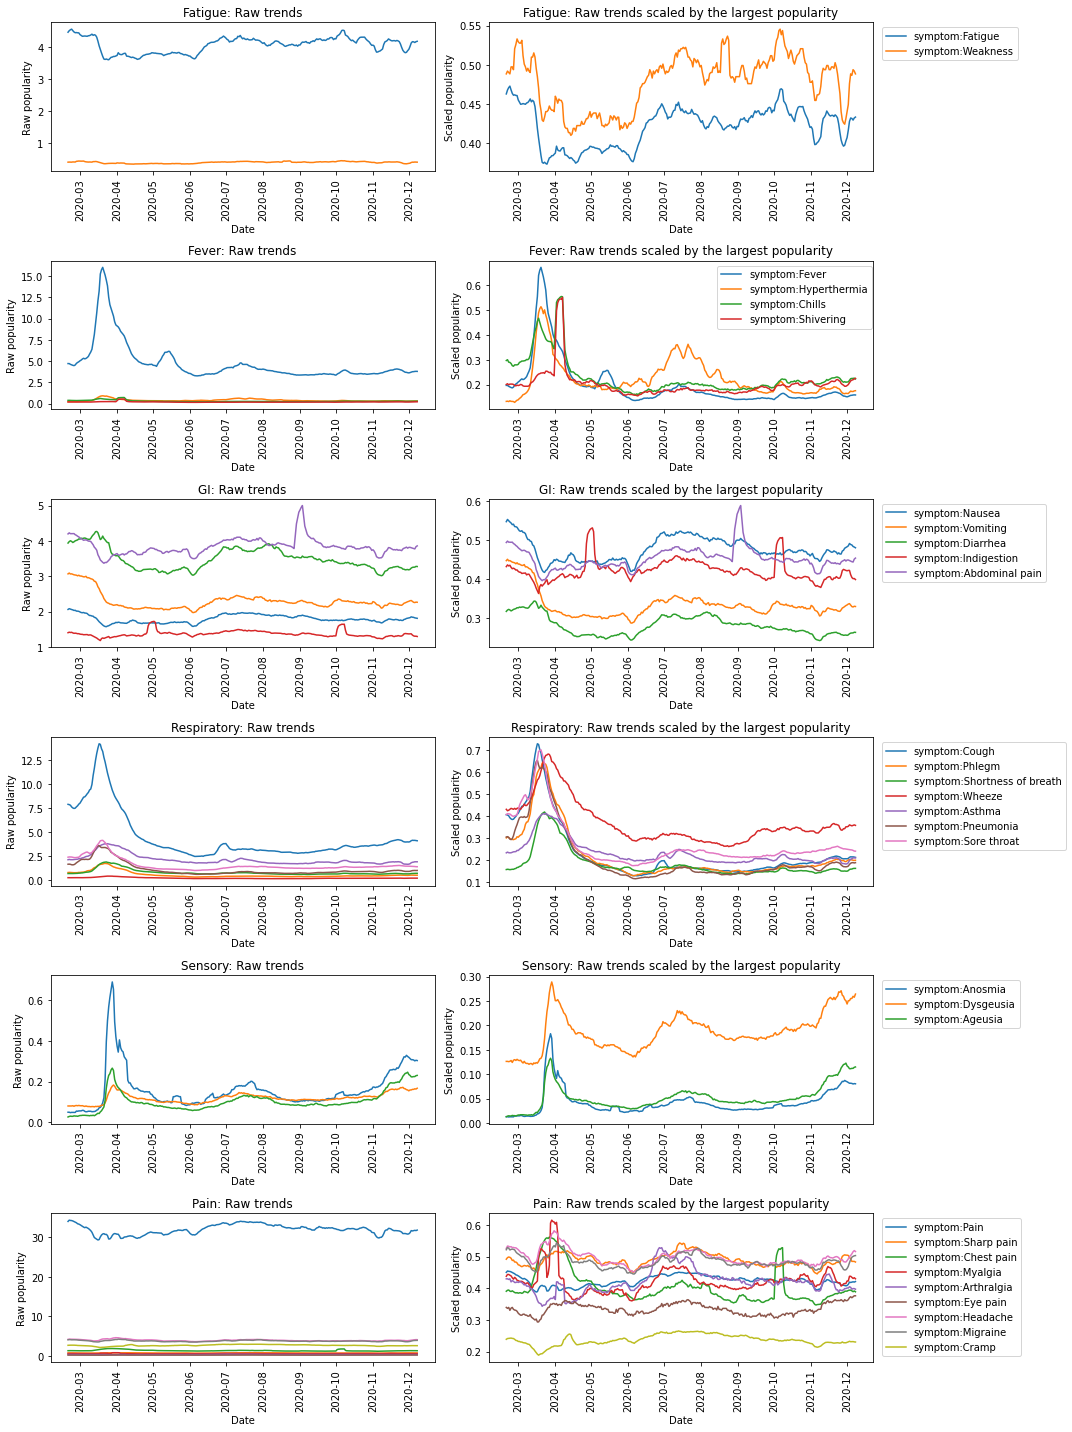

In [80]:
plt.figure(figsize = (15, 20))
i=1
median_df = gs_df.loc[gs_df["geo_id"].isin(geo_list)].groupby("date").median().reset_index()
gsmax = gs_df.max()
for setn in ["Fatigue", "Fever", "GI", "Respiratory", "Sensory", "Pain"]:
    plt.subplot(6, 2, i)
    
    for col in symptom_sets[setn]:
        plt.plot(median_df["date"], median_df[col], label=col)   
    plt.title("%s: Raw trends"%setn)
    plt.xticks(rotation=90)
    plt.xlabel("Date")
    plt.ylabel("Raw popularity")
    
    plt.subplot(6, 2, i+1)    
    for col in symptom_sets[setn]:
        plt.plot(median_df["date"], median_df[col]/gsmax[col], label=col)   
    plt.legend(bbox_to_anchor=(1.01,1))
    plt.title("%s: Raw trends scaled by the largest popularity"%setn)
    plt.xticks(rotation=90)
    plt.xlabel("Date")
    plt.ylabel("Scaled popularity")
    
    i+=2
plt.tight_layout()

###  Geo-wise correlation analysis with a limited number of counties considered

Similarly, now we only consider the 109 counties that are available for all the symptom sets. The number of counties under consideration was greatly reduced, resulting in stronger volatility in the original curve. At the same time, the difference between rawsum and regression is also magnified. There are deeper and wider valleys from June to August on the lines for regression comparing with those for rawsum. 

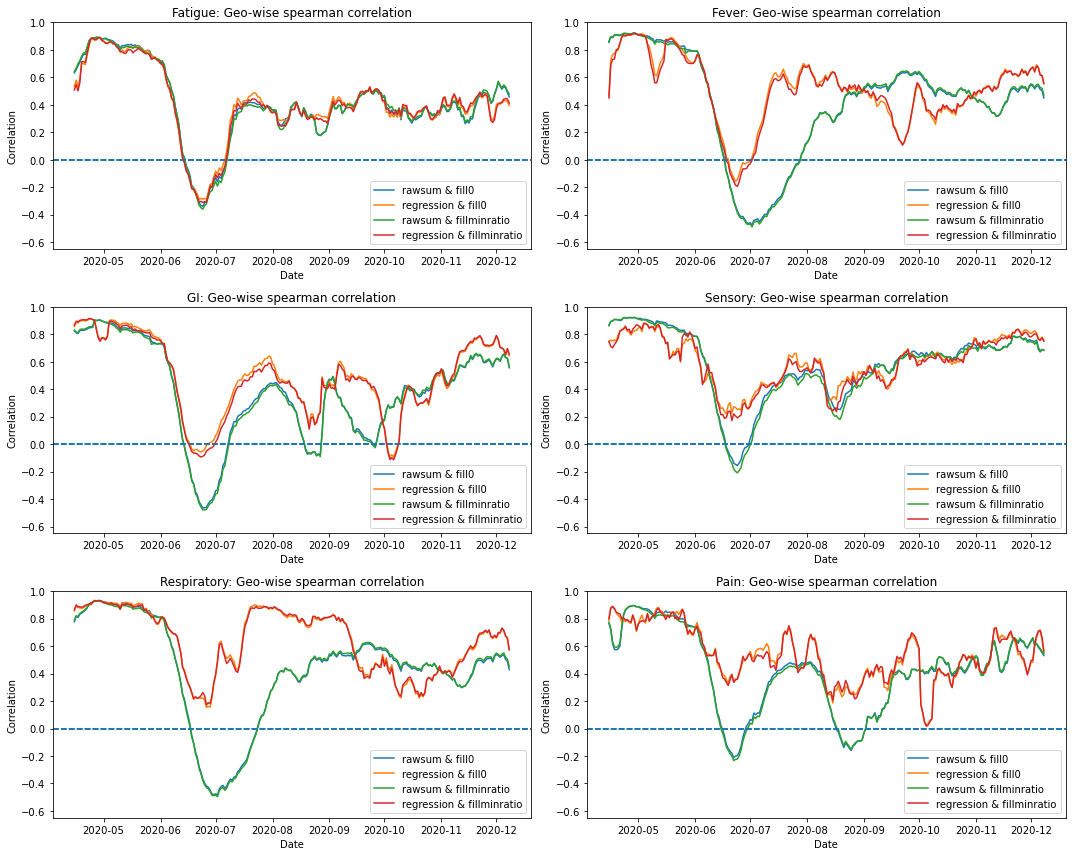

In [92]:
plt.figure(figsize = (15, 12))
i=1
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    for fillmissingness in ["fill0", "fillminratio"]:
        corr_dfs[fillmissingness] = {}
        for method in ["rawsum", "regression"]:
            corr_dfs[fillmissingness][method] = {}        
            corr_dfs[fillmissingness][method][signal] = pd.read_csv("./sensorization_with_as_of_02/geo_wise_varying_as_of/%s_restricted_static_geowise_corr_df_%s_%s.csv"%(signal.lower(),
                                                                                            method,
                                                                                            fillmissingness),
                                                                   parse_dates=["date"]) 
            corr_dfs[fillmissingness][method][signal] = corr_dfs[fillmissingness][method][signal].loc[
                corr_dfs[fillmissingness][method][signal]["date"] >= datetime(2020, 4, 15)
            ]
        
            current_df = corr_dfs[fillmissingness][method][signal]
            plt.plot(current_df["date"], current_df["correlation"], label="%s & %s"%(method, fillmissingness))
            plt.title("%s: Geo-wise spearman correlation"%signal)
            plt.ylim((-0.65, 1))
            plt.xlabel("Date")
            plt.ylabel("Correlation")
            plt.axhline(0, linestyle="--")
            plt.legend()
plt.tight_layout()

Here we draw the popularity trends for symptoms in cluster "Fever" for 109 counties that are shared by all the symptom sets. We can see from the plots below, spatial heterogeneity exists among locations for nearly all the symptoms. It’s very interesting that although the first peak of all symptom popularity almost falls in late March, their peaks around July are shifted from each other, which can be an important cause of negative correlations. 

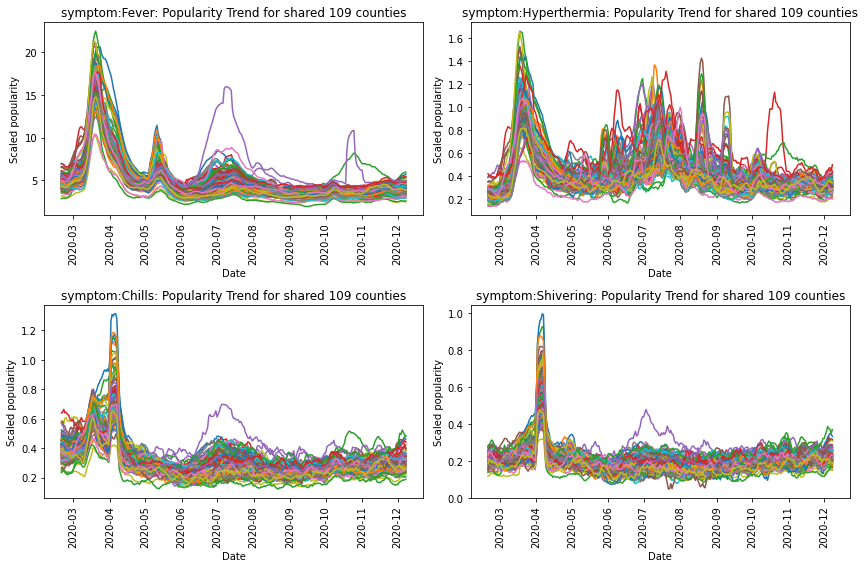

In [81]:
plt.figure(figsize=(12, 8))
i = 1
for sym in symptom_sets["Fever"]:
    plt.subplot(2, 2, i)
    i += 1
    for loc in geo_list:
        subdf = gs_df.loc[gs_df["geo_id"] == loc]
        plt.plot(subdf["date"], subdf[sym])
    plt.xlabel("Date")
    plt.ylabel("Scaled popularity")
    plt.title("%s: Popularity Trend for shared 109 counties"%sym)
    plt.xticks(rotation=90)
plt.tight_layout()

Both time-wise correlation and geo-wise correlation are influenced by the lag in time between users' search behavior and the confirmation of cases. The difference in overall popularity between different symptoms will dramatically magnify or reduce the impact of lag in time in the sensorized indicators. Considering the two methods to combine multiple symptoms, regression outperforms rawsum in two aspects:
- avoid indicators being dominated by some of the symptoms with large overall popularity
- preliminarily consider the impact of lag in time by adjusting the weight of different symptoms in the combinations and the signs of the coefficients




### Sanity Check: Scatter plot for sensorized indicators v.s. confirmed case incidence rates

Here we provide a simple sanity check for the geo-wise Spearman correlation. Scatter plots are generated using regression & fill0 based on sensorized data for reference date 2020-11-15. The calculated Spearman correlation values shown in the titles of these scatter plots match what we see from the geo-wise correlation figures in the main DAP. 

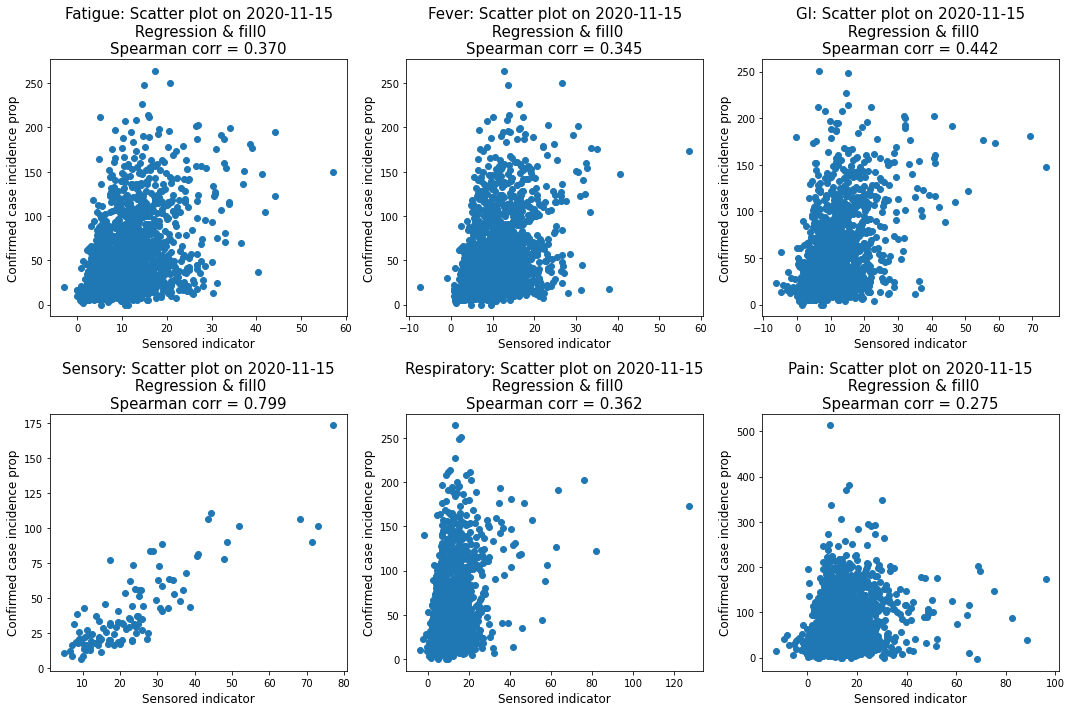

In [52]:
_d = datetime(2020, 11, 15)
method = "regression"
fillmissingness = "fill0"
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]

plt.figure(figsize = (15, 10))
i = 1
for setn in signal_list:
    plt.subplot(2, 3, i)
    i+=1
    df = pd.read_csv("./sensorization_with_as_of/sensored/%s_%s_%s_sensorization_12_14.csv"%(setn, method, fillmissingness), 
                     parse_dates=["date"]).dropna()
    df = df.loc[df["date"] == _d]
    corr = spearmanr(df[["predicted", "cases"]].values,
                              nan_policy="omit")[0]
    plt.title("%s: Scatter plot on 2020-11-15\n Regression & fill0\nSpearman corr = %.3f"%(setn, corr), fontsize=15)
    plt.scatter(df["predicted"], df["cases"])
    plt.xlabel("Sensored indicator", fontsize=12)
    plt.ylabel("Confirmed case incidence prop", fontsize=12)
plt.tight_layout()

### Geo-wise correlation for sensorized data using static sensorization

Recall the data points on the lines of geo-wise correlation in the main DAP have different as of dates. Here, we consider sensorized data generated using static sensorization instead of a blend of static sensorization which means the data points on a single line have the same as of date. Here we computed the geo-wise correlation using data sensorized by models training on all the data on/before 2020-12-01. The same, the methods for filling missingness do not matter much. All the symptom sets except for Sensory show downwards U-shape lines. Compared with the geo-wise correlation plots shown above, as more data available for training, static sensorization will lose the accuracy of early point correction.

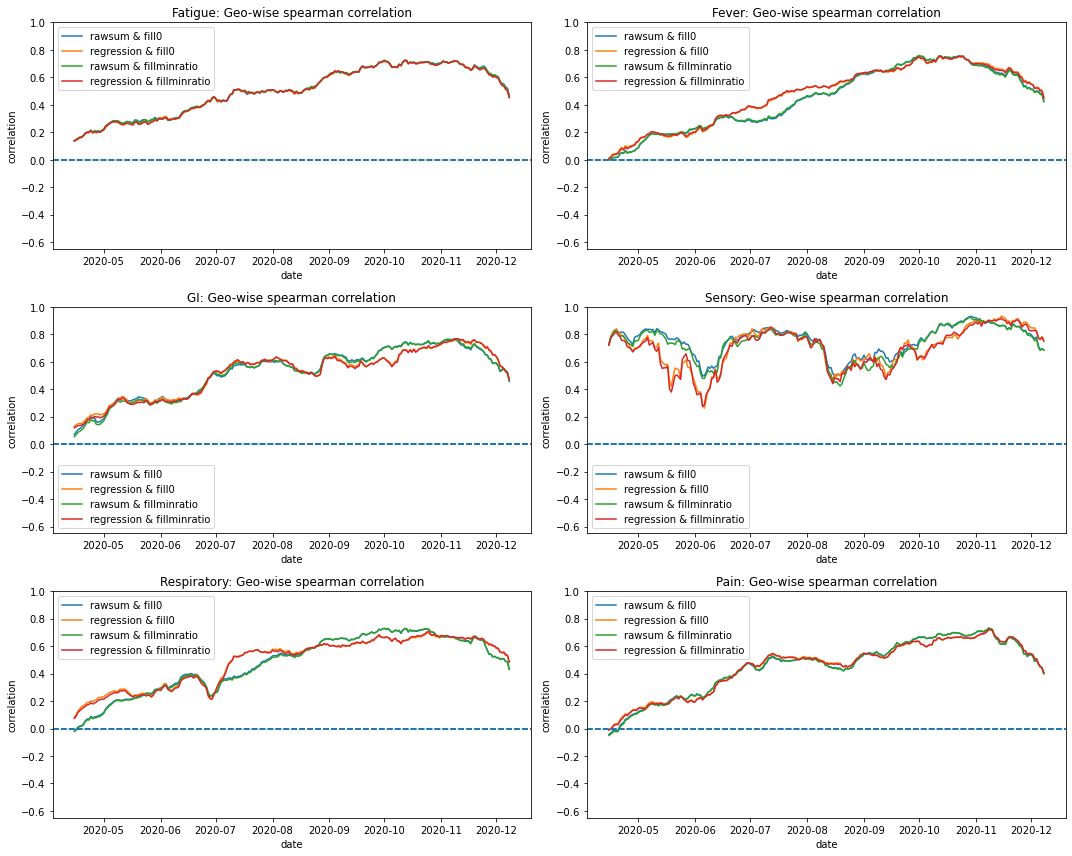

In [93]:
plt.figure(figsize = (15, 12))
i=1
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    for fillmissingness in ["fill0", "fillminratio"]:
        corr_dfs[fillmissingness] = {}
        for method in ["rawsum", "regression"]:
            corr_dfs[fillmissingness][method] = {}        
            corr_dfs[fillmissingness][method][signal] = pd.read_csv("./sensorization_with_as_of_02/geo_wise_final_as_of/%s_static_geowise_corr_df_%s_%s.csv"%(signal.lower(),
                                                                                            method,
                                                                                            fillmissingness),
                                                                   parse_dates=["date"]) 
            corr_dfs[fillmissingness][method][signal] = corr_dfs[fillmissingness][method][signal].loc[
                corr_dfs[fillmissingness][method][signal]["date"] >= datetime(2020, 4, 15)
            ]
        
            current_df = corr_dfs[fillmissingness][method][signal]
            plt.plot(current_df["date"], current_df["correlation"], label="%s & %s"%(method, fillmissingness))
            plt.title("%s: Geo-wise spearman correlation"%signal)
            plt.ylim((-0.65, 1))
            plt.xlabel("date")
            plt.ylabel("correlation")
            plt.axhline(0, linestyle="--")
            plt.legend()
plt.tight_layout()